
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Validation of the synthetic waves and level

inputs required: 
  * historical wave conditions
  * emulator output - synthetic wave conditions
  
in this notebook:
  * Validation of the extreme distributions
  * Analysis of the DWT resposible of extreme TWL events (from the historical and synthetic datasets)
  


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation
from teslakit.plotting.estela import Plot_DWTs_Probs
from teslakit.plotting.wts import Plot_Probs_WT_WT
from teslakit.plotting.climate_emulator import Plot_LevelVariables_Histograms



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# Load data for extremes analysis

HIST_COMPLETE_h = db.Load_HIST_Complete_hourly()
SIM_COMPLETE_h = db.Load_SIM_Complete_hourly()


# --------------------------------------
# set Probabilistic plots parameters

vn_p = 'AWL'          # variable to find annual maxima
n_sim = 0             # select one DWTs - WAVEs simulation
n_clusters_AWT = 6    # number of AWT clusters
n_clusters_DWT = 42   # number of DWT clusters



## Waves - Annual Maxima Return Period for Hs, Tp, AWL

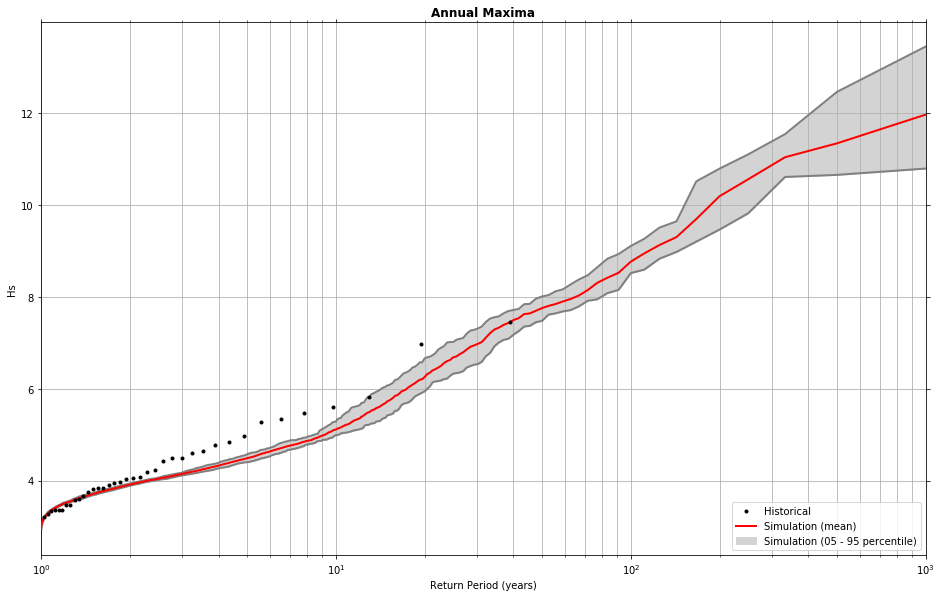

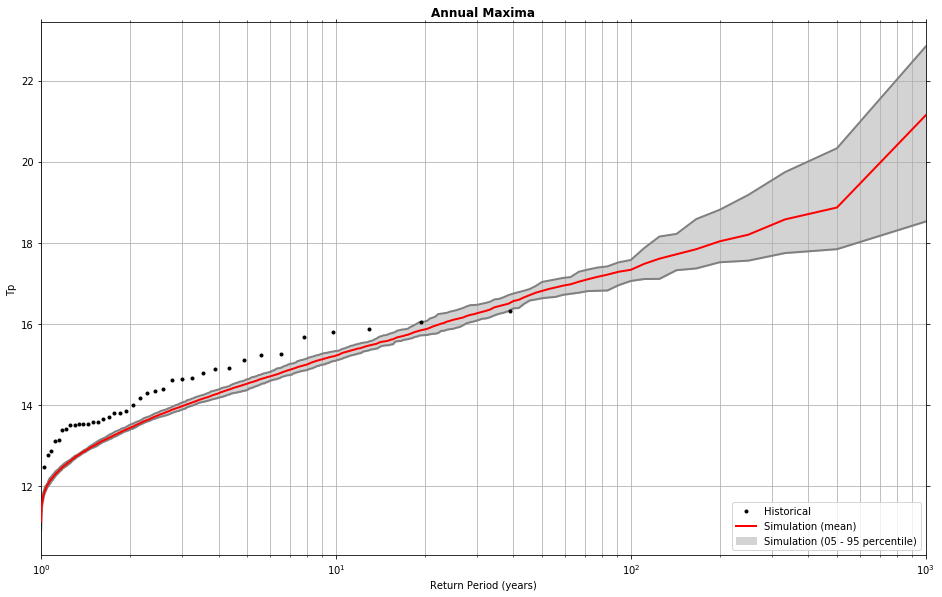

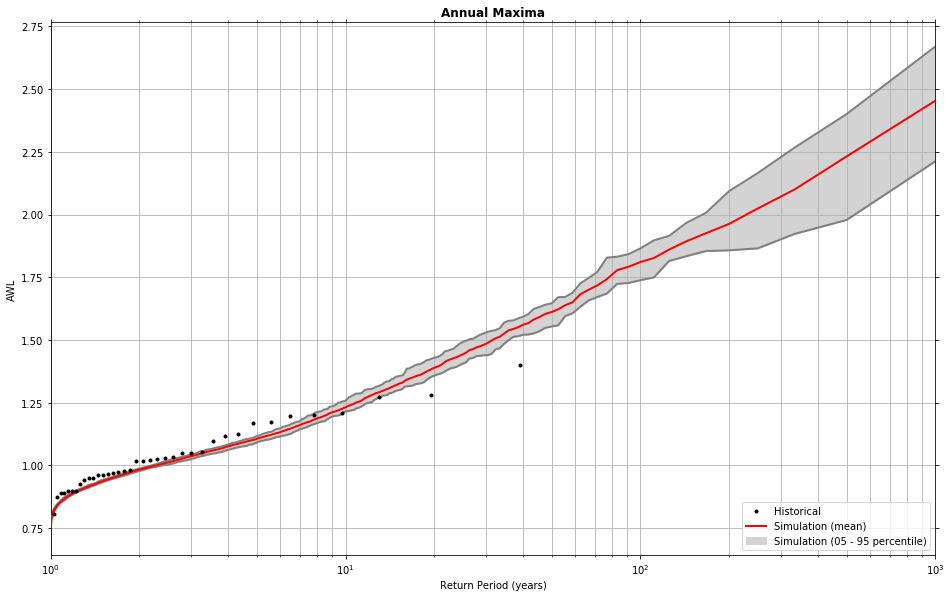

In [4]:
# compare historical and simulations annual maxima (for Hs, Tp, AWL)

vns = ['Hs', 'Tp', 'AWL']
for vn in vns:

    # calculate Annual Maxima values for historical and simulated data
    hist_A = HIST_COMPLETE_h[vn].groupby('time.year').max(dim='time')
    sim_A = SIM_COMPLETE_h[vn].groupby('time.year').max(dim='time')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    


## Waves - Annual Maxima Probabilistic plots

In [5]:
# aux func to select all dataset variables at max by groups
def grouped_max(ds, vn=None, dim=None):
    return ds.isel(**{dim: ds[vn].argmax(dim)})


In [6]:
# reload full historical dataset
HIST_COMPLETE_h = db.Load_HIST_Complete_hourly()

# ensure times round to hour
HIST_COMPLETE_h['time'] = HIST_COMPLETE_h['time'].dt.round('H')

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_COMPLETE_h[vn_p].values[:])))
HIST_COMPLETE_h = HIST_COMPLETE_h.isel(time = ix_nonan)

# Calculate AWL annual maxima dataset
hist_Max = HIST_COMPLETE_h.groupby('time.year').apply(grouped_max, vn=vn_p, dim='time')


In [7]:
# select simulation to plot (for one DWTs - WAVEs simulation)
SIM_COMPLETE_h_n = SIM_COMPLETE_h.sel(n_sim = n_sim)

# Calculate annual maxima
sim_Max = SIM_COMPLETE_h_n.groupby('time.year').apply(grouped_max, vn=vn_p, dim='time')


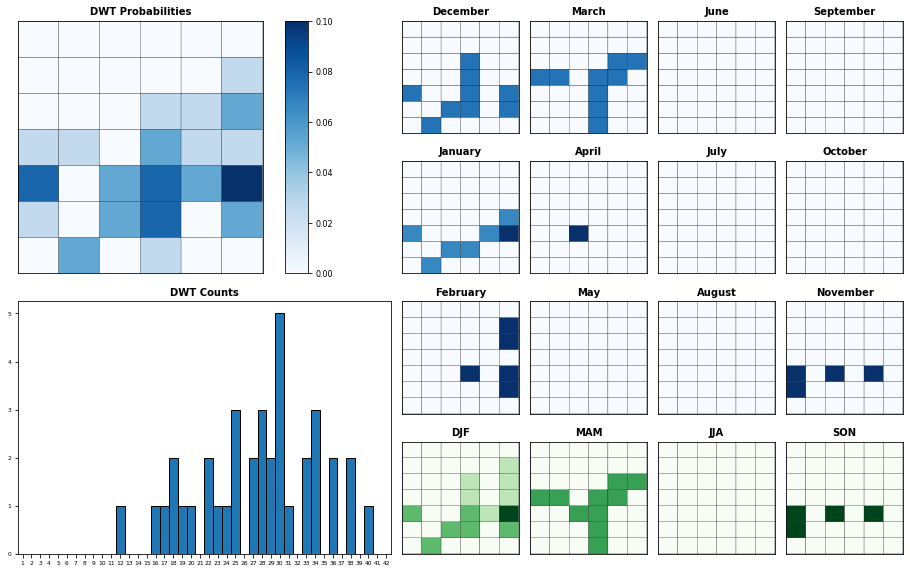

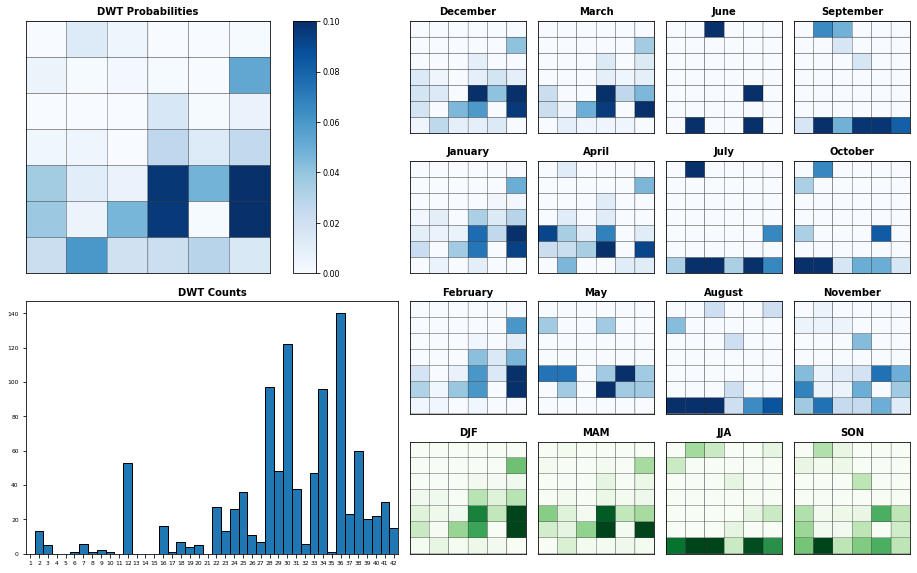

In [8]:
# Annual Maxima DWT probabilities 

# DWTs at AWL annual maxima
hist_DWTs = hist_Max['DWT']
sim_DWTs = sim_Max['DWT']

# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs.values[:], hist_Max.time.values[:], n_clusters_DWT);
Plot_DWTs_Probs(sim_DWTs.values[:], sim_Max.time.values[:], n_clusters_DWT);


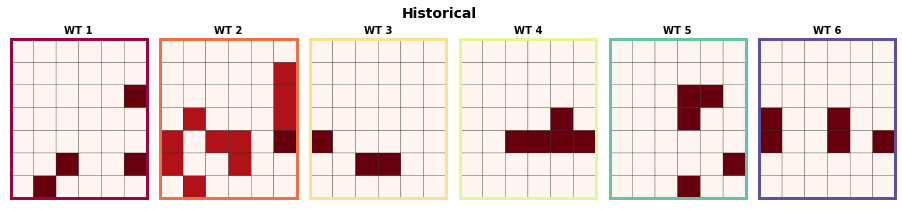

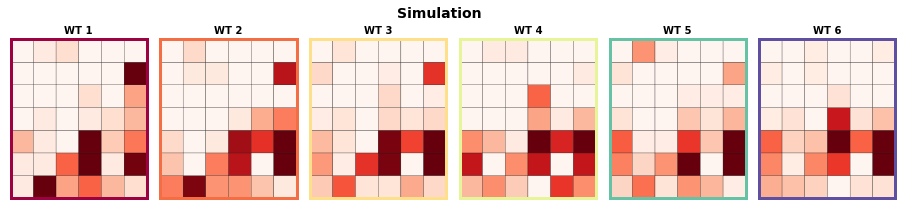

In [9]:
# Annual Maxima AWTs/DWTs Probabilities 

# AWTs at AWL annual maxima
hist_AWTs = hist_Max['AWT']
sim_AWTs = sim_Max['AWT']


# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs.values[:]-1, hist_DWTs.values[:]-1, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical',
);
Plot_Probs_WT_WT(
    sim_AWTs.values[:]-1, sim_DWTs.values[:]-1, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation',
);



## Waves - Peaks Over Threshold Probabilistic plots

In [10]:
# reload full historical dataset
HIST_COMPLETE_h = db.Load_HIST_Complete_hourly()

# ensure times round to hour
HIST_COMPLETE_h['time'] = HIST_COMPLETE_h['time'].dt.round('H')

# remove nans before and after AWL
ix_nonan = np.squeeze(np.argwhere(~np.isnan(HIST_COMPLETE_h[vn_p].values[:])))
HIST_COMPLETE_h = HIST_COMPLETE_h.isel(time = ix_nonan)

# parse to daily
HIST_COMPLETE_d = xds_reindex_daily(HIST_COMPLETE_h)

# Get independent event peaks
percentile = 99
hist_POT = POT(HIST_COMPLETE_d, vn_p, percentile)


In [12]:
# TODO: duplicate values?
_, ix = np.unique(SIM_COMPLETE_h_n['time'], return_index=True)  
SIM_COMPLETE_h_n_fix = SIM_COMPLETE_h_n.isel(time=ix)

# parse to daily
SIM_COMPLETE_d_n = xds_reindex_daily(SIM_COMPLETE_h_n_fix)

# Get independent event peaks
percentile = 99
sim_POT = POT(SIM_COMPLETE_d_n, vn_p, percentile)


In [13]:
# TODO
#Plot_PeaksOverThreshold(hist_POT)
#Plot_PeaksOverThreshold(sim_POT)

# TODO
#Plot_ReturnPeriodValidation(hist_POT, sim_POT);


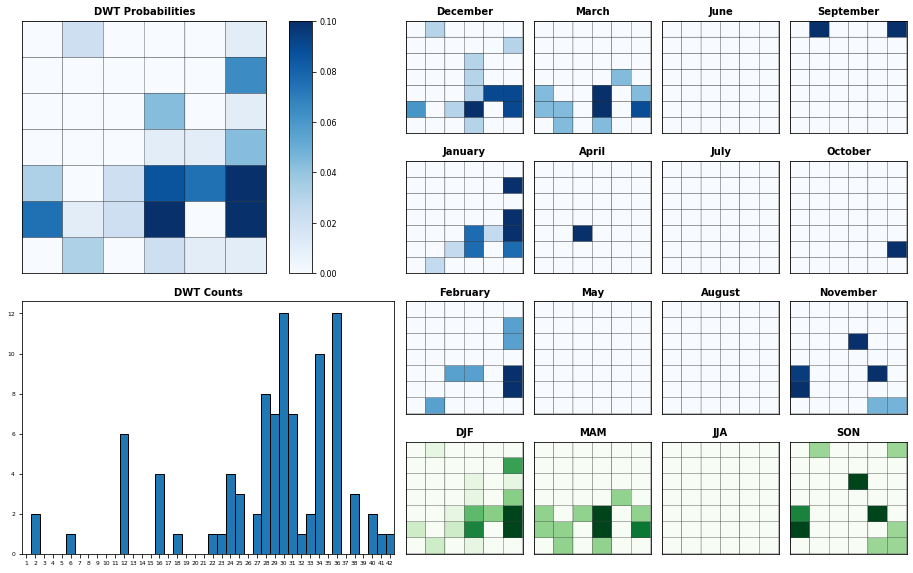

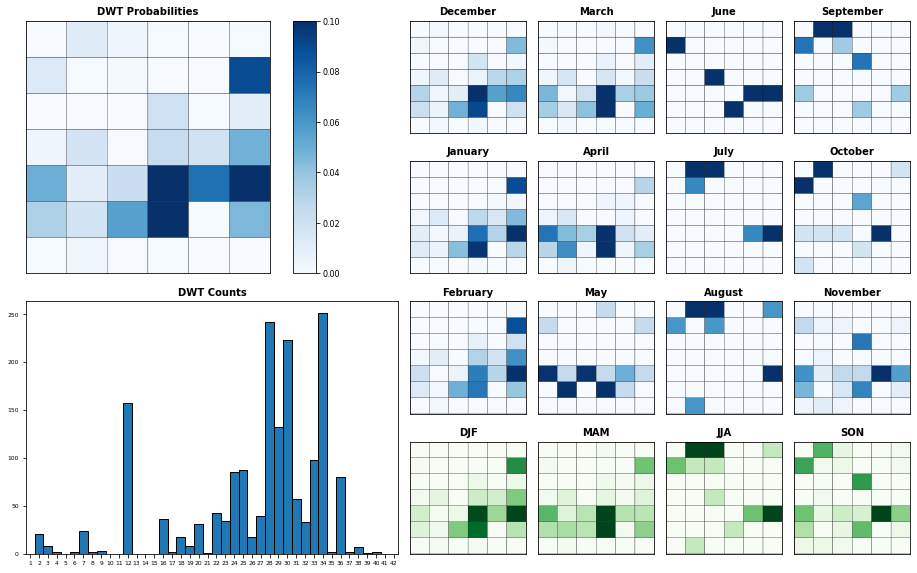

In [21]:
# POT DWT probabilities 

# DWTs at AWL Peaks over Threshold
hist_DWTs = HIST_COMPLETE_d.sel(time=hist_POT.time)['DWT']
sim_DWTs = SIM_COMPLETE_d_n.sel(time=sim_POT.time)['DWT']

# Plot DWTs probabilities by month
Plot_DWTs_Probs(hist_DWTs.values[:], hist_DWTs.time.values[:], n_clusters_DWT);
Plot_DWTs_Probs(sim_DWTs.values[:], sim_DWTs.time.values[:], n_clusters_DWT);


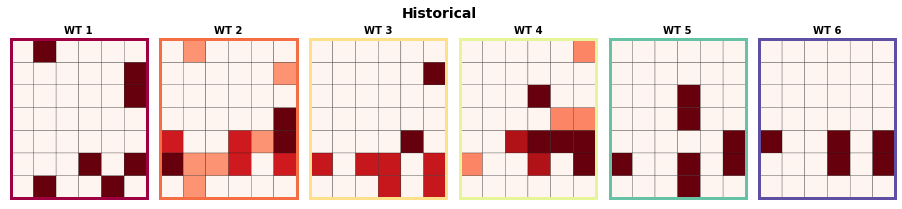

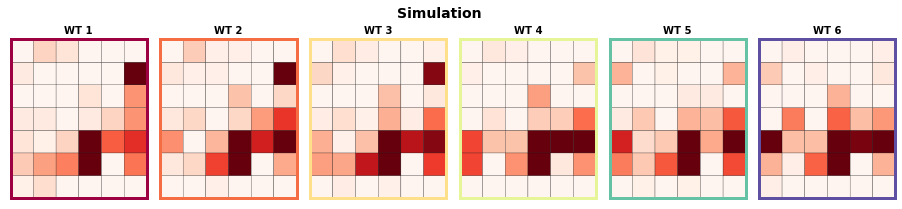

In [22]:
# POT AWTs/DWTs Probabilities 

# AWTs at AWL Peak Over Threshold
hist_AWTs = HIST_COMPLETE_d.sel(time=hist_POT.time)['AWT']
sim_AWTs = SIM_COMPLETE_d_n.sel(time=sim_POT.time)['AWT']

# Plot AWTs/DWTs Probabilities
Plot_Probs_WT_WT(
    hist_AWTs.values[:]-1, hist_DWTs.values[:]-1, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Historical',
);
Plot_Probs_WT_WT(
    sim_AWTs.values[:]-1, sim_DWTs.values[:]-1, n_clusters_AWT, n_clusters_DWT,
    wt_colors=True, ttl = 'Simulation',
);



## Level Variables (level, AT, MMSL, TWL) - Histograms

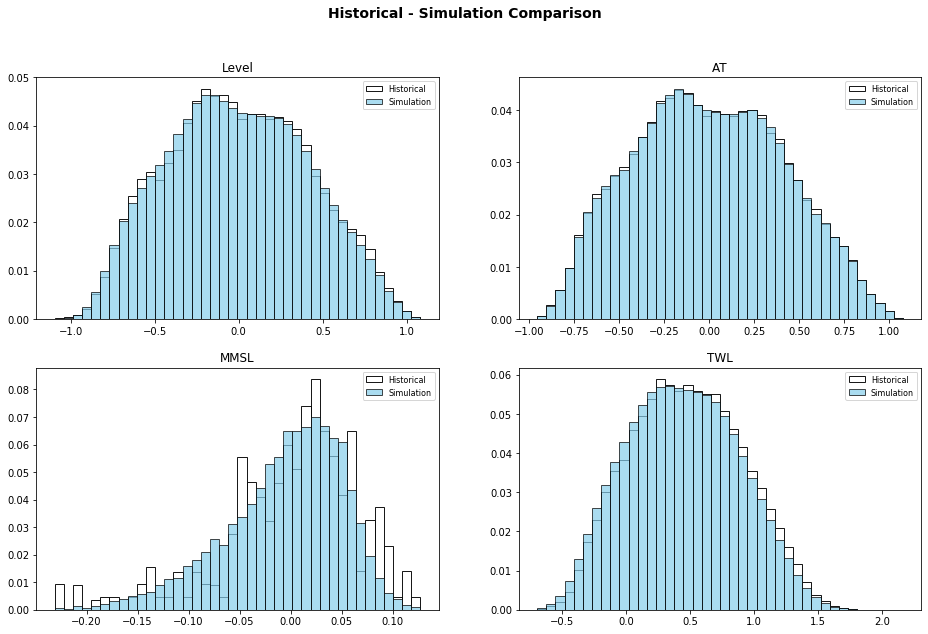

In [23]:
# reload full historical dataset
HIST_COMPLETE_h = db.Load_HIST_Complete_hourly()

# Plot level, AT, MMSL and TWL histogram comparison between historical and simulated data
Plot_LevelVariables_Histograms(HIST_COMPLETE_h, SIM_COMPLETE_h.sel(n_sim = 0));



## TWL - Annual Maxima

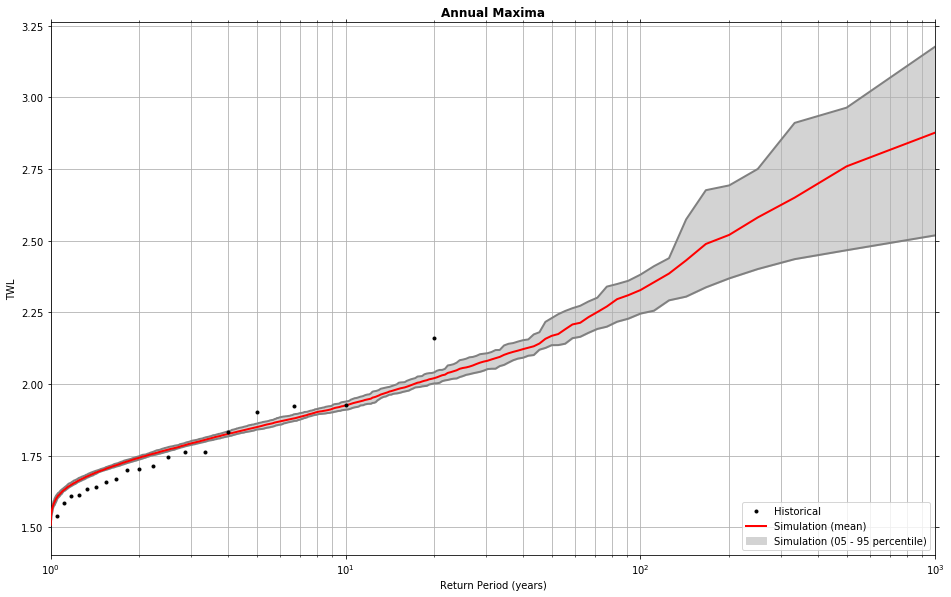

In [24]:
# Plot TWL annual maxima

vn = 'TWL'

# calculate Annual Maxima values for historical and simulated data
hist_A = HIST_COMPLETE_h[vn].groupby('time.year').max(dim='time')
sim_A = SIM_COMPLETE_h[vn].groupby('time.year').max(dim='time')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A);
